In [1]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../../utils")
sys.path.append("../../analysis/utils")


import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# import drawing_utils as drawing
import importlib
import scoring

In [2]:
## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

## Read dataframes

In [3]:
#read in dataframes from each eventType
df_block = pd.read_csv('../../results/csv/df_block_cogsci21.csv')
df_chat = pd.read_csv('../../results/csv/df_chat_cogsci21.csv')
df_exit = pd.read_csv('../../results/csv/df_exit_cogsci21.csv')
df_trial = pd.read_csv('../../results/csv/df_trial_cogsci21.csv')

In [4]:
print('n:', df_block.gameid.nunique())

n: 73


In [5]:
# iterationNames
list(df_trial.iterationName.unique())

['pilot0', 'pilot1', 'pilot2', 'pilot3', 'pilot4', 'pilot4b']

## Exclusion criteria

In [6]:
# 75% Accuracy on 75% of trials
df75 = pd.DataFrame(df_trial.groupby(['gameid', 'trialNum'])['trialScore'].sum()>75).groupby(['gameid']).sum()
df75['trials'] = df75['trialScore']

df75 = df75[df75['trials']>=9]
includedGames = list(df75.reset_index().gameid)

print("Total dyads achieving 75% Accuracy on 75% of trials:",len(df75))

Total dyads achieving 75% Accuracy on 75% of trials: 49


In [7]:
# Exclude from analysis
df_block = df_block[df_block.gameid.isin(includedGames)]
df_chat = df_chat[df_chat.gameid.isin(includedGames)]
df_exit = df_exit[df_exit.gameid.isin(includedGames)]
df_trial = df_trial[df_trial.gameid.isin(includedGames)]

## Task performance

For accuracy and timing, see `ca_ms_stats.Rmd`

## Referring expressions

Two sets of two raters extracted referring expressions from each messages

In [8]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

import nltk
from nltk.tokenize import RegexpTokenizer

import num2words
from num2words import num2words

In [9]:
df_ref_exps = pd.read_csv('../../results/csv/df_ref_exps.csv'.format(analysis_dir))

In [10]:
df_ref_exps.loc[:,'content'] = df_ref_exps.loc[:,'content'].astype(str)

In [11]:
# remove stop words
df_ref_exps['content'] = df_ref_exps['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [12]:
# convert number words

def num_2_words(sentence):
    out = ""
    for word in sentence.split():
        try:
            o = num2words(word)
        except:
            o = word
        out = out+" "+ o
    return out

df_ref_exps['content'] = df_ref_exps['content'].apply(lambda x: num_2_words(x))

In [13]:
# lemmatize

tokenizer = RegexpTokenizer(r'\w+')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]

df_ref_exps['BOW_lemmatized'] = df_ref_exps['content'].apply(lemmatize_text)
df_ref_exps['BOW_lemmatized'] = df_ref_exps['BOW_lemmatized'].apply(lambda x: [i.upper() for i in x] )

In [14]:
df_ref_exps['word_freq'] = df_ref_exps['BOW_lemmatized'].apply(lambda x: Counter(x))
df_ref_exps.head()

,Unnamed: 0,dyad_gameid,trial_num,turn_num,message_id,workerID,block,phrases,scene,tower,message_num,message,content,refExps,leftTarget,rightTarget,tower_pair,rep,BOW_lemmatized,word_freq
0,0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,julia,2,two blue,0.0,0,0,two blue blocks on left and right side of left...,two blue,NaN,L,Pi,L_Pi,1,"[TWO, BLUE]","{'TWO': 1, 'BLUE': 1}"
1,1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,justin,2,two blue blocks,0.0,0,0,two blue blocks on left and right side of left...,two blue blocks,NaN,L,Pi,L_Pi,1,"[TWO, BLUE, BLOCK]","{'TWO': 1, 'BLUE': 1, 'BLOCK': 1}"
2,2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,julia,2,two red,0.0,0,1,two red block on top of left blue block just p...,two red,NaN,L,Pi,L_Pi,1,"[TWO, RED]","{'TWO': 1, 'RED': 1}"
3,3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,justin,2,two red block,0.0,0,1,two red block on top of left blue block just p...,two red block,NaN,L,Pi,L_Pi,1,"[TWO, RED, BLOCK]","{'TWO': 1, 'RED': 1, 'BLOCK': 1}"
4,4,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,4,d39dd7ca-1fde-56c1-9d41-a10b16b3d17d,julia,2,two red,0.0,0,2,two red block one space apart on right line,two red,NaN,L,Pi,L_Pi,1,"[TWO, RED]","{'TWO': 1, 'RED': 1}"


In [15]:
df_ref_exps['BOW_concat'] = df_ref_exps['BOW_lemmatized'].apply(lambda x: ' '.join(x))

In [16]:
# # Get word frequency distributions for all ppts
# df_ref_exps = df_ref_exps.groupby(['dyad_gameid','rep'])['content'].apply(lambda x: ' '.join(x)).reset_index()
# df_ref_exps['word_freq'] = df_ref_exps['content'].apply(lambda x: Counter(x.split()))
# df_ref_exps.head()

In [17]:
# create support
split_words = df_ref_exps['BOW_concat'].apply(lambda x: x.split())
all_words = list(pd.Series([st for row in split_words for st in row]).unique())
support = {}
for word in all_words:
    support[word] = 0.000000001
    
def get_pdist(row):
    num_words = np.sum(list(row['word_freq'].values()))
    pdist = support.copy()
    for i, (word, count) in enumerate(row['word_freq'].items()):
        pdist[word] = count/num_words
    return pdist

In [18]:
df_all_words = df_ref_exps[['dyad_gameid', 'rep', 'BOW_concat']]

In [19]:
def jsdiv(P, Q):
    """Compute the Jensen-Shannon divergence between two probability distributions.

    Input
    -----
    P, Q : array-like
        Probability distributions of equal length that sum to 1
    """

    def _kldiv(A, B):
        return np.sum([v for v in A * np.log2(A/B) if not np.isnan(v)])

    P = np.array(P)
    Q = np.array(Q)

    M = 0.5 * (P + Q)

    return 0.5 * (_kldiv(P, M) +_kldiv(Q, M))

In [20]:
df_ref_exps['word_pdist'] = df_ref_exps.apply(get_pdist, axis = 1)
df_ref_exps['word_pdist_numeric'] = df_ref_exps['word_pdist'].apply(lambda dist: list(dist.values()))

In [40]:
for w in all_words:
    df_all_words.loc[:,w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))

In [22]:
df_all_words_reps = df_all_words.groupby('rep').agg(sum)
df_all_words_reps

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_10369/3932202342.py:1: FutureWarning: The operation <built-in function sum> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  df_all_words_reps = df_all_words.groupby('rep').agg(sum)


,TWO,BLUE,BLOCK,RED,ONE,EXACT,CONSTRUCTION,LEFT,RIGHT,SIDE,...,OUSE,TILE,BLOC,SHAP,HORIZTONAL,MAKE,ANGLE,CENTRED,LEFTMOST,TWR
rep,,,,,,,,,,,,,,,,,,,,,
1,623,1085,1100,1035,224,0,0,3,5,9,...,0,3,1,0,2,1,1,1,0,0
2,512,1129,499,979,184,5,3,11,10,13,...,0,0,0,1,0,0,0,0,1,1
3,320,868,181,777,131,0,0,5,7,7,...,1,1,0,0,0,0,0,0,0,0
4,75,209,35,184,20,0,0,2,1,2,...,0,0,0,0,0,0,0,0,0,0


#### Change in word frequency plot 



In [23]:
df_ref_exps_rep = df_ref_exps.groupby('rep')['BOW_concat'].apply(lambda group:' '.join(group)).reset_index()
df_ref_exps_rep['word_freq'] = df_ref_exps_rep['BOW_concat'].apply(lambda x: Counter(x.split()))
df_ref_exps_rep['word_pdist'] = df_ref_exps_rep.apply(get_pdist, axis=1)
df_ref_exps_rep['word_pdist_numeric'] = df_ref_exps_rep['word_pdist'].apply(lambda dist: list(dist.values()))
df_ref_exps_rep.index=df_ref_exps_rep['rep']

In [24]:
rep_a = 1
rep_b = 4

rep_diff = {}

for _, (k, rep_a_v) in enumerate(df_ref_exps_rep.loc[rep_a,'word_pdist'].items()):
    rep_diff[k] = df_ref_exps_rep.loc[rep_b,'word_pdist'][k] - rep_a_v

In [25]:
n = 6
top_n = dict(sorted(rep_diff.items(), key=lambda item: item[1], reverse=True)[:n])

top_n

{'L': 0.05734655611812832,
 'C': 0.03298536181665175,
 'SHAPE': 0.032698562616607654,
 'BLUE': 0.02154686921943194,
 'U': 0.020250494326782383,
 'TALL': 0.01816359509904137}

In [26]:
bottom_n = dict(sorted(rep_diff.items(), key=lambda item: item[1], reverse=False)[:n])

bottom_n

{'BLOCK': -0.15443041001392815,
 'TWO': -0.03777088343850854,
 'HORIZONTAL': -0.02285785639184289,
 'ONE': -0.01672335567019553,
 'VERTICAL': -0.01624128327697643,
 'RED': -0.009534645383217022}

In [27]:
df_grouped = df_ref_exps.groupby('rep').agg({'BOW_lemmatized': 'sum'})

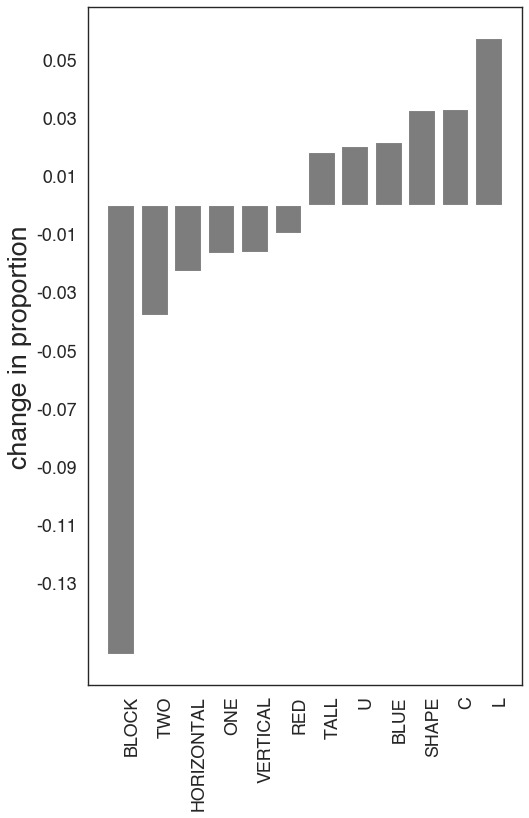

<Figure size 640x480 with 0 Axes>

In [28]:
from matplotlib.ticker import FormatStrFormatter

font = {'fontname':'Helvetica'}
sns.set_theme(style='white')

x_limit = 6

labels, values = zip(*rep_diff.items())

# sort your values in descending order
indSort_high = np.argsort(values)[::-1]
indSort_low = np.argsort(values)

# rearrange your data
#labels = np.array(labels)[indSort_high][:x_limit][::-1]
labels = np.concatenate([np.array(labels)[indSort_low][:x_limit],np.array(labels)[indSort_high][:x_limit][::-1]])
#values = np.array(values)[indSort_high][:x_limit][::-1]
values = np.concatenate([np.array(values)[indSort_low][:x_limit], np.array(values)[indSort_high][:x_limit][::-1]])

indexes = np.arange(len(labels))

bar_width = 0.35

fig = plt.figure(num=None, figsize=(7, 11), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.bar(indexes, values, color = "#7D7D7D")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# add labels
plt.yticks(fontsize=16, **font)
plt.xticks(indexes + bar_width, labels,  rotation='vertical', fontsize=16, **font)
plt.ylabel("change in proportion", size = 24, **font)
plt.yticks(np.arange(-.13,.06, .02))
ax.axes.get_xaxis().set_visible(True)
#plt.title("highest delta words", size = 24, **font)
plt.show()
plt.savefig('plots/word_delta_hist.pdf')

### groupby ppt

In [29]:
df_all_words_ppt_reps = df_all_words.groupby(['dyad_gameid','rep']).agg(sum).reset_index()
df_all_words_ppt_reps.head()

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_10369/367029973.py:1: FutureWarning: The operation <built-in function sum> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  df_all_words_ppt_reps = df_all_words.groupby(['dyad_gameid','rep']).agg(sum).reset_index()


,dyad_gameid,rep,TWO,BLUE,BLOCK,RED,ONE,EXACT,CONSTRUCTION,LEFT,...,OUSE,TILE,BLOC,SHAP,HORIZTONAL,MAKE,ANGLE,CENTRED,LEFTMOST,TWR
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,28,33,42,28,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,2,36,40,48,32,30,3,3,2,...,0,0,0,0,0,0,0,0,0,0
2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,3,30,44,50,35,35,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,4,8,8,12,8,6,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0208-b497c845-b076-45c9-b958-a62a3ae6e65f,1,0,44,2,48,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df_all_words_ppt_reps.to_csv("../../results/csv/ppt_rep_word_frequencies.csv")

In [37]:
# Get word frequency distributions for all ppts
df_refexp_trial = df_ref_exps.groupby(['gameid','repNum','trialNum'])['content'].apply(lambda x: ' '.join(x)).reset_index()
df_refexp_trial['word_freq'] = df_refexp_trial['content'].apply(lambda x: Counter(x.split()))
df_refexp_trial

KeyError: 'repNum'

In [ ]:
df_all_words_trial = df_refexp_trial[['gameid', 'repNum', 'trialNum' ,'content']]

for w in all_words:
    df_all_words_trial.loc[:,w] = df_all_words_trial['content'].apply(lambda row: int(w in row.split()))


# df_all_words_trials = df_all_words_trial.groupby('repNum').agg(sum)
# r0_mat = np.array(df_all_words[df_all_words.repNum == 0].iloc[:,3:])
# r3_mat = np.array(df_all_words[df_all_words.repNum == 3].iloc[:,3:])

In [11]:
df_all_words_trial

NameError: name 'df_all_words_trial' is not defined

## Cluster analyses

In [17]:
df_all_words_trial

,gameid,repNum,trialNum,content,two,blue,blocks,red,block,one,...,fifth,lock,beign,third,fourth,anoher,certicals,being,squares,ablue
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,0,two blue blocks two blue two red block two red...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,1,two blue block two blue two red blocks two red...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,2,blue block two red blue two red blue block blu...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,3,same exact construction the same exact constru...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,4,one blue block two red blocks blue two reds on...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,2,7,a blue block blue a blue one blue two reds two...,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
584,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,2,8,a blue block blue two reds two reds blue blue ...,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
585,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,3,9,a blue blue two reds two reds a blue blue ablu...,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
586,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,3,10,a red red the same same two blues two blues a ...,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
tsne = TSNE()

In [ ]:
# visualizations using tsne, colored by clusters above (I don't know if this is a silly thing to do)

np.random.seed(2)
tsne = TSNE()

X_embedded = tsne.fit_transform(df_all_words_trial[(df_all_words_trial.repNum == 0)].loc[:,'two':'ablue'].append(df_all_words_trial[(df_all_words_trial.repNum == 3)].loc[:,'two':'ablue']))
#cluster_labels = r0_clustering_original.labels_ + r3_clustering_original.labels_
cluster_labels = np.concatenate((r3_clustering_original.labels_,r3_clustering_original.labels_)) # both reps colored by final cluster assignment

# r3_X_embedded = tsne.fit_transform(df_all_words_trial[(df_all_words_trial.repNum == 3)].loc[:,'two':'ablue'])
# r3_cluster_labels = r3_clustering_original.labels_

colors = df_all_words_trial[(df_all_words_trial.repNum == 0)].append(df_all_words_trial[(df_all_words_trial.repNum == 3)]).repNum

n = int(len(X_embedded[:,0])/2)

# for i, x in enumerate(X_embedded[:n,0]):
#     plt.plot([x,X_embedded[i+n,0]], [X_embedded[i,1],X_embedded[i+n,1]], color = (0,0,0,0.05) )

palette = np.array(sns.color_palette("jet_r", len(set(cluster_labels))))

palette[[(Counter(cluster_labels[n:])[x] <= 3) for x in set(cluster_labels)]] = (0.8,0.8,0.8)

palette[[(Counter(cluster_labels[n:])[x] > 3) for x in set(cluster_labels)]] = sns.color_palette("bright", len(set(cluster_labels)) - sum([(Counter(cluster_labels[n:])[x] <= 3) for x in set(cluster_labels)]))

palette = list(palette)

palette[5] = ([0.4,0.0,0.8])

palette[6] = ([0.75,0.05,0.07])

palette[7] = ([0.2,0.7,0.3])

sns.set_style('white')

plt.figure(figsize=(8,8))
sns.scatterplot(X_embedded[:n,0], X_embedded[:n,1], hue=cluster_labels[0:n], legend='full', palette=palette, alpha=0.8, s=160, linewidth=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off

# plt.savefig('../results/plots/rep1_clusters.pdf')

plt.figure(figsize=(8,8))

# for i, x in enumerate(X_embedded[:n,0]):
#     plt.plot([x,X_embedded[i+n,0]], [X_embedded[i,1],X_embedded[i+n,1]], color = palette[cluster_labels[i+n]], alpha=0.1)

sns.scatterplot(X_embedded[n:,0], X_embedded[n:,1], hue=cluster_labels[n:], legend='full', palette=palette, alpha=0.8, s=160, linewidth=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False)

# plt.savefig('../results/plots/rep4_clusters.pdf')


## Wrangle description tagging data

In [43]:
df_ratings = pd.read_csv('../results/csv/JJ_ratings.csv')

In [44]:
df_ratings

,rater,gameid,trialNum,turnNum,repNum,refType,refExp
0,Julia,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,0,4,0,block,1
1,Julia,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,0,6,0,block,1
2,Julia,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,0,8,0,block,1
3,Julia,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,0,10,0,block,1
4,Julia,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,0,12,0,block,2
...,...,...,...,...,...,...,...
8555,Justin,5156-be8ae9d7-0f4f-4f69-9d5b-fa70394f9dea,7,0,2,tower,2
8556,Justin,5156-be8ae9d7-0f4f-4f69-9d5b-fa70394f9dea,8,0,2,tower,2
8557,Justin,5156-be8ae9d7-0f4f-4f69-9d5b-fa70394f9dea,9,0,3,tower,2
8558,Justin,5156-be8ae9d7-0f4f-4f69-9d5b-fa70394f9dea,10,0,3,tower,2


In [45]:
df_trial['trialNum']

,Unnamed: 0,_id,iterationName,gameid,time,assignmentId,leftTarget,rightTarget,trialNum,turnNum,...,individualPracticeAttempts,word_count,char_count,n_messages,time_final_block,total_block_duration,total_chat_duration,total_duration,diff,flagged
0,0,5ef783a1ce2f7f58fcd0a354,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593279e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,vertical,horizontal,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,1,5ef783c3ce2f7f58fcd0a35b,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593279e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,vertical,horizontal,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,2,5ef784d6ce2f7f58fcd0a3a0,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593280e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,C,Pi,0.0,0,...,NaN,106.0,494.0,7.0,270221.0,95525.0,163658.0,259183.0,11038.0,False
3,3,5ef7859cce2f7f58fcd0a3d3,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593280e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,L,C,1.0,0,...,NaN,88.0,421.0,6.0,191955.0,63542.0,120868.0,184410.0,7545.0,False
4,4,5ef7863ece2f7f58fcd0a405,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593280e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,L,Pi,2.0,0,...,NaN,58.0,257.0,3.0,157681.0,67865.0,87195.0,155060.0,2621.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031,9,5f59284d1034572e66881c7f,pilot4b,5156-be8ae9d7-0f4f-4f69-9d5b-fa70394f9dea,1.599679e+12,3UN61F00H0PZ24YYZXDCVV9O86W5R7,C,Pi,7.0,0,...,0.0,8.0,38.0,1.0,36449.0,22475.0,13899.0,36374.0,75.0,True
1032,10,5f59288d1034572e66881c9f,pilot4b,5156-be8ae9d7-0f4f-4f69-9d5b-fa70394f9dea,1.599679e+12,3UN61F00H0PZ24YYZXDCVV9O86W5R7,L,C,8.0,0,...,0.0,9.0,41.0,1.0,36889.0,17640.0,19081.0,36721.0,168.0,True
1033,11,5f5928bd1034572e66881cb6,pilot4b,5156-be8ae9d7-0f4f-4f69-9d5b-fa70394f9dea,1.599679e+12,3UN61F00H0PZ24YYZXDCVV9O86W5R7,Pi,C,9.0,0,...,0.0,8.0,38.0,1.0,19053.0,7232.0,11690.0,18922.0,131.0,True
1034,12,5f5928f91034572e66881cd5,pilot4b,5156-be8ae9d7-0f4f-4f69-9d5b-fa70394f9dea,1.599679e+12,3UN61F00H0PZ24YYZXDCVV9O86W5R7,Pi,L,10.0,0,...,0.0,9.0,47.0,1.0,31994.0,10605.0,21226.0,31831.0,163.0,True


In [19]:
df_refexp_unprocessed = pd.read_csv('../results/csv/JJ_content.csv')

In [20]:
# new ratings

df_refexp_unprocessed.columns

Index(['gameid', 'time', 'assignmentId', 'leftTarget', 'rightTarget',
       'trialNum', 'turnNum', 'repNum', 'message', 'timeElapsedInTurn',
       'timeElapsedInTrial', 'eventType', 'practice',
       'individualPracticeAttempts', 'turnStartTime', 'trialStartTime',
       'word_count', 'char_count', 'flagged', 'block_justin', 'toer_justin',
       'scene_justin', 'Flagged', 'phrases_justin', 'block_julia',
       'tower_juli', 'scene_juli', 'phrases_julia', 'content'],
      dtype='object')

In [22]:
len(df_refexp_unprocessed)

2143

In [23]:
len(df_trial)

667

In [28]:
df_messages = df_chat[~df_chat.practice].reset_index(drop=True)

In [ ]:
# df_messages_for_annotation = 
df_messages[['gameid',]]

In [30]:
df_messages['content']

0                put a blue block three from the left~~~ 
1       place a red block on top of the left side of t...
2       Now place a blue block on top of that that lin...
3       remove that last blue block, place it on top o...
4       place a red block on the second grid from the ...
                              ...                        
2138    perfect, and on the right we have a long C, wi...
2139    lol, same house as last time I guess, vertical...
2140    and now on the right we have an L shape, start...
2141    haha dont worry about it, it happens~~~ we'll ...
2142    and on the left it's a long C with a blue at t...
Name: content, Length: 2143, dtype: object

### Tagging referring expressions

Manually extract referring expressions.
Need to know the number of (blocks, towers, scenes) that these refer to.
Each ref exp might refer to more than one block (e.g. "2x blue").

I think what we did before is:
- list referring expressions (e.g. "a red block, another red")
- enter number referred to in message:
    - Blocks
    - Towers
    - Scenes
- Flag any unusual behavior (off-task)
- Each messsage tagged by both Justin and Julia (took mean?)


In [40]:
df_refexp_unprocessed.flagged

0       False
1       False
2       False
3       False
4       False
        ...  
2138     True
2139     True
2140     True
2141     True
2142     True
Name: flagged, Length: 2143, dtype: bool

In [49]:
len(df_messages.groupby('gameid'))

49

In [50]:
len(df_messages)

2143